In [75]:
import pandas as pd
import csv
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import shapiro
from sklearn.impute import KNNImputer

### Import the cleaned data from MapReduce

In [2]:
#GitHub won't allow uploading the MapReduced file as it is too large, so it is not in the submission directory

pwd = os.getcwd()
path = Path(pwd)
data_path = str(path.parent.absolute()) + "/tweet_output/part-00000.txt"
tweets = pd.read_csv(data_path, header=None, index_col=0, sep=",", quoting=csv.QUOTE_NONE)

In [3]:
print(tweets.shape)

(1600000, 2)


In [4]:
tweets.iloc[1599999]

1                        Thu May 21 23:36:24 PDT 2009 
2     MsTeagan and by the way I rewatched Sun Godde...
Name: 999999, dtype: object

In [5]:
tweets.head()

,1,2
0,,
0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
10,Mon Apr 06 22:20:16 PDT 2009,spring break in plain city its snowing\t
100,Mon Apr 06 22:26:33 PDT 2009,Body Of Missing Northern Calif Girl Found Po...
1000,Mon Apr 06 23:28:50 PDT 2009,JonathanRKnight silver_tulip27 Um that would ...


In [6]:
tweets.tail()

,1,2
0,,
999995,Thu May 21 23:36:19 PDT 2009,healingsinger thank you i needed that \t
999996,Thu May 21 23:36:20 PDT 2009,vactress httpbitlycADea Maybe this is more y...
999997,Thu May 21 23:36:21 PDT 2009,Brat13 Hell Windows 7 will be out of my price...
999998,Thu May 21 23:36:22 PDT 2009,jigardoshi neah i wish just reminiscing read...
999999,Thu May 21 23:36:24 PDT 2009,MsTeagan and by the way I rewatched Sun Godde...


In [7]:
tweets = tweets.reset_index(drop=True)

In [8]:
tweets = tweets.rename(columns = {1:'Date', 2:'Tweet'})

In [9]:
tweets.head()

,Date,Tweet
0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
2,Mon Apr 06 22:20:16 PDT 2009,spring break in plain city its snowing\t
3,Mon Apr 06 22:26:33 PDT 2009,Body Of Missing Northern Calif Girl Found Po...
4,Mon Apr 06 23:28:50 PDT 2009,JonathanRKnight silver_tulip27 Um that would ...


In [10]:
#Strip the time as the sentiment will be calculated per day
tweets.Date = pd.to_datetime(tweets.Date).dt.date

/tmp/ipykernel_11192/1265027921.py:2: FutureWarning: Parsed string " Mon Apr 06 22:19:45 PDT 2009 " included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets.Date = pd.to_datetime(tweets.Date).dt.date


In [11]:
tweets.head()

,Date,Tweet
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,2009-04-06,is upset that he cant update his Facebook by ...
2,2009-04-06,spring break in plain city its snowing\t
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...


### Sentiment analysis

In [12]:
sentiment = SentimentIntensityAnalyzer()

In [13]:
def format_output(output_dict):
    polarity = "neutral"

    if(output_dict['compound'] >= 0.05):
        polarity = "positive"

    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"

    return polarity

def get_score(output_dict):
    return output_dict['compound']

def predict_sentiment(text):
    output_dict =  sentiment.polarity_scores(text)
    return format_output(output_dict)

def predict_score(text):
    output_dict =  sentiment.polarity_scores(text)
    return get_score(output_dict)

In [14]:
tweets["vader_prediction"] = tweets["Tweet"].apply(predict_sentiment)

In [15]:
tweets.head()

,Date,Tweet,vader_prediction
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...,negative
1,2009-04-06,is upset that he cant update his Facebook by ...,negative
2,2009-04-06,spring break in plain city its snowing\t,neutral
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...,negative
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...,negative


In [16]:
tweets["vader_score"] = tweets["Tweet"].apply(predict_score)

In [31]:
tweets.head()

,Date,Tweet,vader_prediction,vader_score
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...,negative,-0.3818
1,2009-04-06,is upset that he cant update his Facebook by ...,negative,-0.7269
2,2009-04-06,spring break in plain city its snowing\t,neutral,0.0000
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...,negative,-0.5267
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...,negative,-0.8519


### Time-series

In [18]:
tweets_bydate = tweets.copy()

In [19]:
tweets_bydate["Date"] = tweets_bydate.Date.astype(str).str[8:]

In [20]:
tweets_bydate

,Date,Tweet,vader_prediction,vader_score
0,06,switchfoot httptwitpiccom2y1zl Awww thats a ...,negative,-0.3818
1,06,is upset that he cant update his Facebook by ...,negative,-0.7269
2,06,spring break in plain city its snowing\t,neutral,0.0000
3,06,Body Of Missing Northern Calif Girl Found Po...,negative,-0.5267
4,06,JonathanRKnight silver_tulip27 Um that would ...,negative,-0.8519
...,...,...,...,...
1599995,21,healingsinger thank you i needed that \t,positive,0.3612
1599996,21,vactress httpbitlycADea Maybe this is more y...,neutral,0.0000
1599997,21,Brat13 Hell Windows 7 will be out of my price...,negative,-0.3182
1599998,21,jigardoshi neah i wish just reminiscing read...,positive,0.4019


In [21]:
tweets_bydate = tweets_bydate.groupby("Date", as_index=False)['vader_score'].mean()

In [22]:
tweets_bydate

,Date,vader_score
0,01,0.166057
1,02,0.169276
2,03,0.165365
3,04,0.157093
4,05,0.175336
5,06,0.172488
6,07,0.172253
7,09,0.175466
8,10,0.206029
9,11,0.158807


<function matplotlib.pyplot.show(close=None, block=None)>

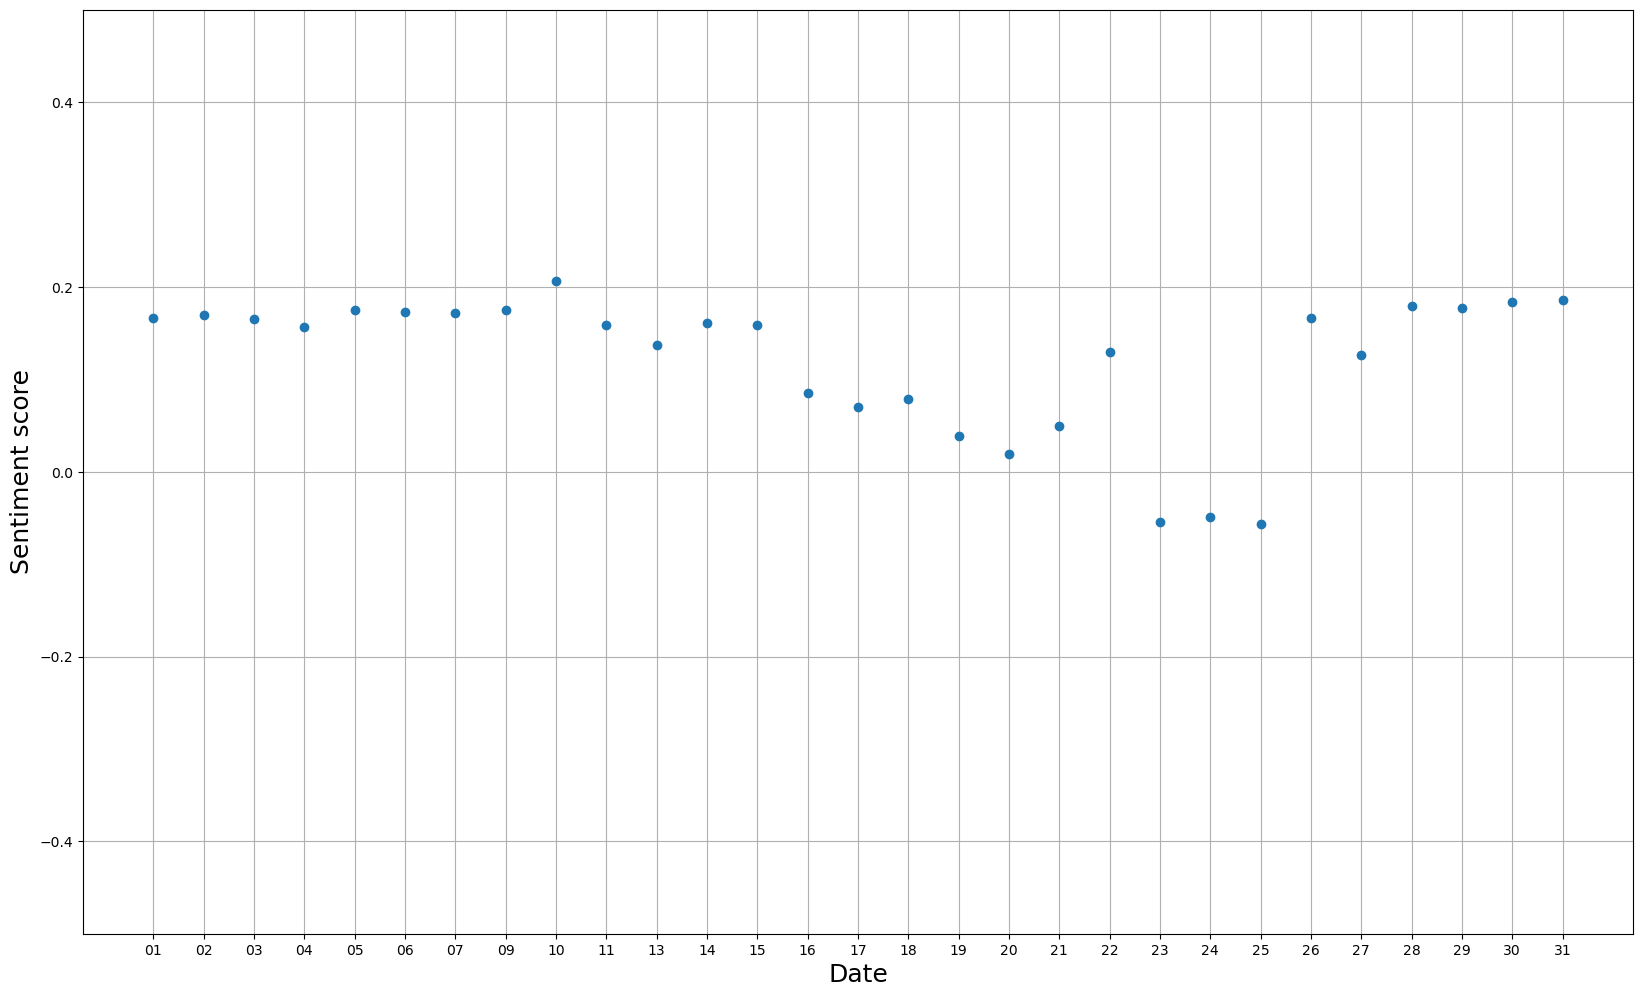

In [23]:
fig, ax=plt.subplots(figsize=(20, 12))

ax.plot(tweets_bydate["Date"], tweets_bydate["vader_score"], linestyle="",marker="o")

plt.ylim([-.5,.5])
plt.grid()

plt.xlabel("Date", fontsize = 18)
plt.ylabel("Sentiment score", fontsize = 18)

plt.show

In [24]:
correlation = tweets_bydate["Date"].corr(tweets_bydate["vader_score"])

correlation 

-0.33328512734495946

In [59]:
tweets_byday = tweets.groupby(["Date"], as_index=False)["vader_score"].mean()

In [60]:
tweets_byday

,Date,vader_score
0,2009-04-06,0.140128
1,2009-04-07,0.156389
2,2009-04-17,0.194937
3,2009-04-18,0.173630
4,2009-04-19,0.177163
5,2009-04-20,0.165969
6,2009-04-21,0.169604
7,2009-05-01,0.169209
8,2009-05-02,0.173652
9,2009-05-03,0.165379


<function matplotlib.pyplot.show(close=None, block=None)>

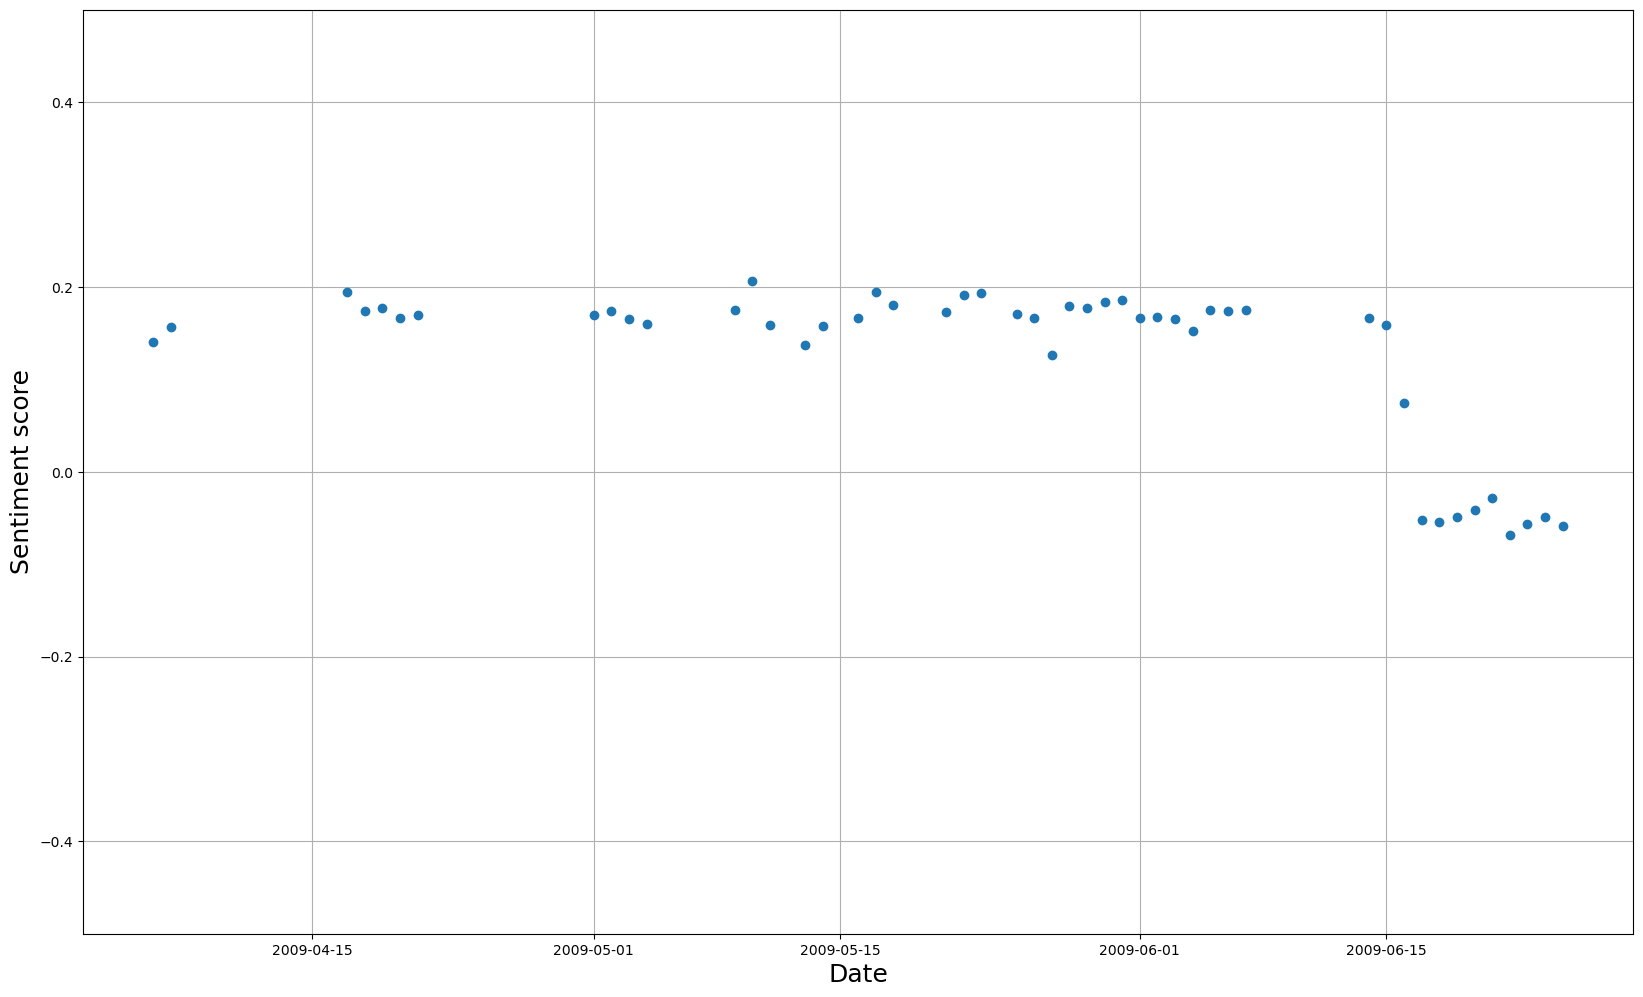

In [61]:
fig, ax=plt.subplots(figsize=(20, 12))

ax.plot(tweets_byday["Date"], tweets_byday["vader_score"], linestyle="",marker="o")

plt.ylim([-.5,.5])
plt.grid()

plt.xlabel("Date", fontsize = 18)
plt.ylabel("Sentiment score", fontsize = 18)

plt.show
#data_test['y'].plot(ax=ax, label='test')
#ax.legend();

### Impute missing dates

In [217]:
start = tweets_byday.Date[0]
end = tweets_byday.Date[len(tweets_byday)-1]

all_dates = pd.date_range(start=start,end=end,freq='D')
len(all_dates)

81

In [218]:
score_imputed = tweets_byday.copy()

In [219]:
score_imputed.set_index('Date', inplace= True)

In [220]:
score_imputed

,vader_score
Date,
2009-04-06,0.140128
2009-04-07,0.156389
2009-04-17,0.194937
2009-04-18,0.173630
2009-04-19,0.177163
2009-04-20,0.165969
2009-04-21,0.169604
2009-05-01,0.169209
2009-05-02,0.173652


In [221]:
score_imputed = score_imputed.reindex(all_dates)

score_imputed = score_imputed.rename_axis('Date')
Dates = score_imputed.index

score_imputed.head(15)

,vader_score
Date,
2009-04-06,0.140128
2009-04-07,0.156389
2009-04-08,NaN
2009-04-09,NaN
2009-04-10,NaN
2009-04-11,NaN
2009-04-12,NaN
2009-04-13,NaN
2009-04-14,NaN


In [222]:
# Format the data for KNN processing
score_imputed["month"] = score_imputed.index.month
score_imputed["day"] = score_imputed.index.day
score_imputed.reset_index(drop=True, inplace = True)

In [223]:
score_imputed.head(20)

,vader_score,month,day
0,0.140128,4,6
1,0.156389,4,7
2,NaN,4,8
3,NaN,4,9
4,NaN,4,10
5,NaN,4,11
6,NaN,4,12
7,NaN,4,13
8,NaN,4,14
9,NaN,4,15


### Impute missing values

In [209]:
len(tweets_byday)

48

In [210]:
#There are 33 missing values, 69% of the original dataset - too high a percentage to impute
len(score_imputed) - len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(score_imputed)

(33, 0.6875, 0.4074074074074074)

In [211]:
#Score is non-parametric, so non-parametric imputation is most appropriate.
print(shapiro(tweets_byday['vader_score']))

ShapiroResult(statistic=0.6544499397277832, pvalue=2.265662102374222e-09)


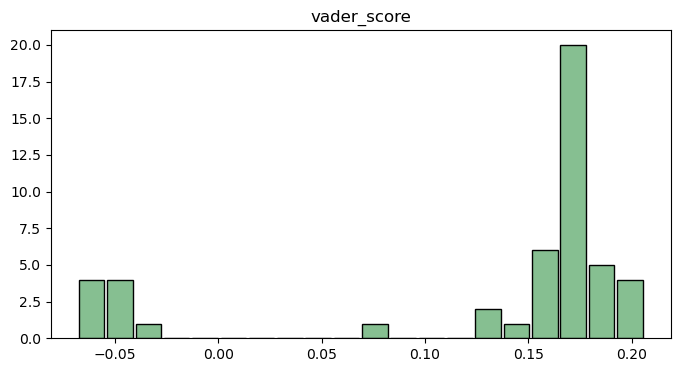

In [212]:
ax = tweets_byday.hist(column='vader_score', edgecolor='black', figsize=(8,4), bins= 20, grid=False, sharex=False, color='#86bf91', zorder=2, rwidth=0.9)

In [226]:
knn_imputer = KNNImputer(n_neighbors=3)

In [227]:
score_imputed["vader_score"] = knn_imputer.fit_transform(score_imputed)

In [228]:
score_imputed["Date"] = Dates

In [229]:
score_imputed.head(20)

,vader_score,month,day,Date
0,0.140128,4,6,2009-04-06
1,0.156389,4,7,2009-04-07
2,0.157328,4,8,2009-04-08
3,0.179295,4,9,2009-04-09
4,0.180101,4,10,2009-04-10
5,0.180101,4,11,2009-04-11
6,0.151369,4,12,2009-04-12
7,0.151369,4,13,2009-04-13
8,0.153735,4,14,2009-04-14
9,0.161089,4,15,2009-04-15


<function matplotlib.pyplot.show(close=None, block=None)>

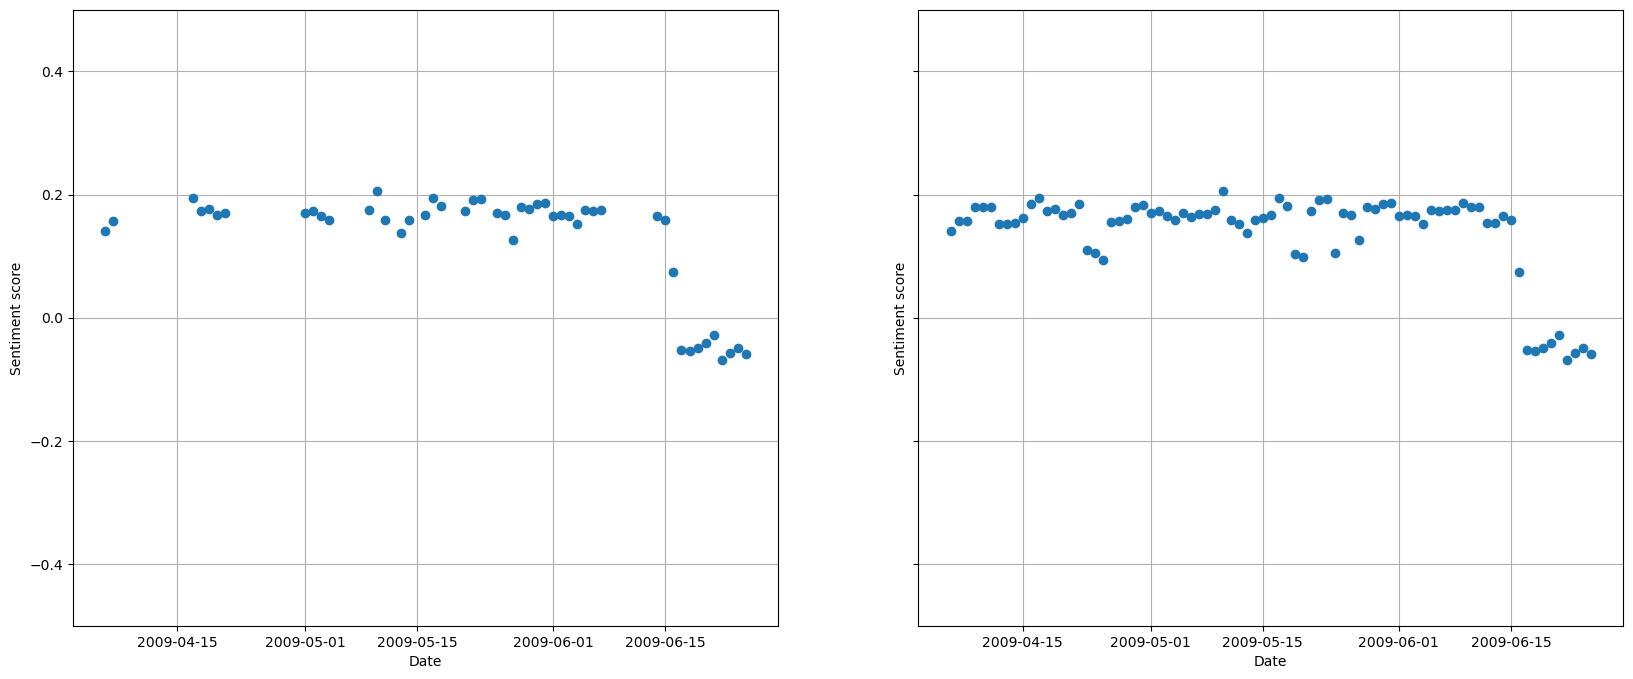

In [230]:
#plt.plot(score_imputed.index, score_imputed['vader_score'], linestyle="",marker="o")

fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey = True)
plt.ylim([-.5,.5])

axs[0].plot(tweets_byday["Date"], tweets_byday['vader_score'], linestyle="",marker="o")
axs[0].grid()

axs[1].plot(score_imputed["Date"], score_imputed['vader_score'], linestyle="",marker="o")
axs[1].grid()

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Sentiment score')

plt.show